#0.import and random seeds


In [24]:
import torch
import torch.nn as nn
import torch.distributions as td
import torch.utils.data
from tqdm import tqdm
from copy import deepcopy
import os
import math
import matplotlib.pyplot as plt
#dataset
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [25]:
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)                           # Python built-in random module
    np.random.seed(seed)                        # NumPy random generator
    torch.manual_seed(seed)                     # PyTorch CPU random seed
    torch.cuda.manual_seed(seed)                # PyTorch current GPU random seed
    torch.cuda.manual_seed_all(seed)            # PyTorch all GPUs random seed
    torch.backends.cudnn.deterministic = True   # Ensure deterministic behavior in cuDNN
    torch.backends.cudnn.benchmark = False      # Disable auto-optimization to prevent non-deterministic behavior
    os.environ["PYTHONHASHSEED"] = str(seed)    # Control hash-based randomness in Python

set_seed(42)


#1.Dataset  
just copy the code provided by the professor



In [26]:
def subsample(data, targets, num_data, num_classes):
    idx = targets < num_classes  # Select samples with class labels less than num_classes (e.g., only classes 0, 1, 2)
    new_data = data[idx][:num_data].unsqueeze(1).to(torch.float32) / 255  # Select the first num_data images and normalize to [0,1]
    new_targets = targets[idx][:num_data]  # Select corresponding labels for the subsampled images
    return torch.utils.data.TensorDataset(new_data, new_targets)  # Create a TensorDataset with the filtered images and labels

num_train_data = 2048
num_classes = 3

train_tensors = datasets.MNIST(
    "data/", train=True, download=True,
    transform=transforms.Compose([transforms.ToTensor()])  # Convert images to tensors
)

test_tensors = datasets.MNIST(
    "data/", train=False, download=True,
    transform=transforms.Compose([transforms.ToTensor()])  # Convert images to tensors
)
train_data = subsample(
    train_tensors.data, train_tensors.targets,
    num_train_data, num_classes
)
test_data = subsample(
    test_tensors.data, test_tensors.targets,
    num_train_data, num_classes
)

batch_size=32
mnist_train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True
)
mnist_test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=False
)
latent_dim=2
M=latent_dim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#2.GaussianPrior and Encoder/Decoder
Just copy the code provided by the professor


In [27]:
class GaussianPrior(nn.Module):
    def __init__(self, M):
        """
        Define a Gaussian prior distribution with zero mean and unit variance.

                Parameters:
        M: [int]
           Dimension of the latent space.
        """
        super(GaussianPrior, self).__init__()
        self.M = M
        self.mean = nn.Parameter(torch.zeros(self.M), requires_grad=False)
        self.std = nn.Parameter(torch.ones(self.M), requires_grad=False)

    def forward(self):
        """
        Return the prior distribution.

        Returns:
        prior: [torch.distributions.Distribution]
        """
        return td.Independent(td.Normal(loc=self.mean, scale=self.std), 1)

class GaussianEncoder(nn.Module):
    def __init__(self, encoder_net):
        """
        Define a Gaussian encoder distribution based on a given encoder network.

        Parameters:
        encoder_net: [torch.nn.Module]
            The encoder network that takes a tensor of dimension
            `(batch_size, feature_dim1, feature_dim2)` as input
            and outputs a tensor of dimension `(batch_size, 2M)`,
            where M is the dimension of the latent space.
        """
        super(GaussianEncoder, self).__init__()
        self.encoder_net = encoder_net

    def forward(self, x):
        """
        Given a batch of input data, return a Gaussian distribution over the latent space.

        Parameters:
        x: [torch.Tensor]
            A tensor of dimension `(batch_size, feature_dim1, feature_dim2)`.

        Returns:
        A Gaussian distribution with computed mean and standard deviation.
        """
        mean, std = torch.chunk(self.encoder_net(x), 2, dim=-1)
        return td.Independent(td.Normal(loc=mean, scale=torch.exp(std)), 1)

        # Example:
        # z = torch.randn(4, 10)  # Assume z is a tensor of shape [batch_size=4, 10]
        # a, b = torch.chunk(z, 2, dim=-1)
        # a and b will have shape [4, 5], as the tensor is split into two parts along the last dimension.
def new_encoder():
        encoder_net = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.Softmax(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.Softmax(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.Flatten(),
            nn.Linear(512, 2 * M),
        )
        return encoder_net
class GaussianDecoder(nn.Module):
    def __init__(self, decoder_net):
        """
        Define a Gaussian decoder distribution based on a given decoder network.

        Parameters:
        decoder_net: [torch.nn.Module]
            The decoder network that takes a tensor of dimension `(batch_size, M)`
            as input, where M is the dimension of the latent space, and outputs a
            tensor of dimension `(batch_size, feature_dim1, feature_dim2)`.
        """
        super(GaussianDecoder, self).__init__()
        self.decoder_net = decoder_net
        # self.std = nn.Parameter(torch.ones(28, 28) * 0.5, requires_grad=True)
        # In case you want to learn the standard deviation of the Gaussian.

    def forward(self, z):
        """
        Given a batch of latent variables, return a Gaussian distribution over the data space.

        Parameters:
        z: [torch.Tensor]
            A tensor of dimension `(batch_size, M)`, where M is the dimension of the latent space.

        Returns:
        A Gaussian distribution with computed mean and a fixed standard deviation.
        """
        means = self.decoder_net(z)
        return td.Independent(td.Normal(loc=means, scale=1e-1), 3) #note the variance of decoder is fixed
        # This defines a 784-dimensional independent normal distribution, where each dimension is independent.
def new_decoder():
        decoder_net = nn.Sequential(
            nn.Linear(M, 512),
            nn.Unflatten(-1, (32, 4, 4)),
            nn.Softmax(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=0),
            nn.Softmax(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.Softmax(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
        )
        return decoder_net

#3.VAE
having changed the provided code ,so that for each mini-batch of data, we randomly sample a decoder and take a gradient step to optimize the ELBO


In [28]:
class VAE(nn.Module):
    def __init__(self, prior, decoders, encoder):
        """
        Variational Autoencoder (VAE) with multiple decoders.

        Parameters:
        prior: [torch.nn.Module]
            The prior distribution over the latent space.
        decoders: [list of torch.nn.Module]
            A list containing multiple decoders.
        encoder: [torch.nn.Module]
            The encoder network that maps input data to a latent distribution.
        """
        super(VAE, self).__init__()
        self.prior = prior
        self.decoders = nn.ModuleList(decoders)  # Use ModuleList to allow PyTorch to properly track parameters
        self.encoder = encoder

    def elbo(self, x, decoder_idx):
        """
        Compute the Evidence Lower Bound (ELBO) for a given input and selected decoder.

        Parameters:
        x: [torch.Tensor]
            The input data tensor.
        decoder_idx: [int]
            The index of the decoder to be used.

        Returns:
        The computed ELBO value.
        """
        q = self.encoder(x)  # Encode input into a latent distribution
        z = q.rsample()  # Sample from the latent distribution using the reparameterization trick
        decoder = self.decoders[decoder_idx]  # Select the corresponding decoder

        elbo = torch.mean(
            decoder(z).log_prob(x) - q.log_prob(z) + self.prior().log_prob(z)
        )  # Compute ELBO using the likelihood, posterior, and prior

        return elbo

    def sample(self, decoder_idx, n_samples=1):
        """
        Generate samples from the specified decoder.

        Parameters:
        decoder_idx: [int]
            The index of the decoder to be used.
        n_samples: [int, default=1]
            The number of samples to generate.

        Returns:
        A batch of generated samples.
        """
        z = self.prior().sample(torch.Size([n_samples]))  # Sample from the prior distribution
        decoder = self.decoders[decoder_idx]  # Select the corresponding decoder
        return decoder(z).sample()  # Generate samples from the decoder

    def forward(self, x, decoder_idx):
        """
        Compute the negative ELBO for optimization.

        Parameters:
        x: [torch.Tensor]
            The input data tensor.
        decoder_idx: [int]
            The index of the decoder to be used.

        Returns:
        The negative ELBO value.
        """
        return -self.elbo(x, decoder_idx)


#4.Training vae


In [29]:
def train(model, optimizers, data_loader, epochs, device):
    num_decoders = len(model.decoders)
    #total epoch should depende on the number of decoders
    total_epochs = epochs * num_decoders
    num_steps = len(data_loader) * total_epochs
    epoch = 0

    losses = []

    def noise(x, std=0.05):
        eps = std * torch.randn_like(x)
        return torch.clamp(x + eps, min=0.0, max=1.0)

    with tqdm(range(num_steps)) as pbar:
        for step in pbar:
            try:
                x = next(iter(data_loader))[0]
                x = noise(x.to(device))
                model=model
                idx = torch.randint(0, num_decoders, (1,)).item()
                #for each mini-batch of data, we randomly sample a decoder
                #and take a gradient step to optimize the ELBO of  that decoder
                # if we [1]
                optimizer = optimizers[idx]
                optimizer.zero_grad()
                loss = model(x, decoder_idx=idx) #correspond to the changed part in VAE
                loss.backward()
                optimizer.step()

                loss_val = loss.detach().cpu().item()
                losses.append(loss_val)

                if step % 5 == 0:
                    pbar.set_description(
                        f"epoch={epoch}, step={step}, decoder={idx}, loss={loss_val:.1f}"
                    )
                if (step + 1) % len(data_loader) == 0:
                    epoch += 1
            except KeyboardInterrupt:
                print(f"Stopped at epoch {epoch}, step {step}, loss {loss_val:.1f}")
                break

    return losses


In [30]:
#because in part B we need 10 independent VAEs with  decoders 1,2,3, so I define a new train function
#S is the number of the decoders
def train_single_vae(seed, save_path, S, epochs_per_decoder):
    set_seed(seed)
    decoders = [GaussianDecoder(new_decoder()) for _ in range(S)]
    #instantiating  S randomly initialized decoders
    # note: set_seed(1001) only ensure the next time we run set_seed(1001), it's still the SAME randomly three decoders
    # it will not destroy of the randomness of three different decoders
    # [dd1,dd2,dd0]  [dd1,dd0,dd2]
    encoder = GaussianEncoder(new_encoder())
    prior = GaussianPrior(M)

    model = VAE(prior, decoders, encoder).to(device)
   # I just use the learning rate provided
    optimizers = [
        torch.optim.Adam(
            list(model.encoder.parameters()) + list(decoder.parameters()), lr=1e-3
        )
        for decoder in model.decoders
    ]

    losses = train(model, optimizers, mnist_train_loader, epochs_per_decoder, device)

    torch.save(model.state_dict(), save_path)
    plt.figure()
    plt.plot(range(5000, len(losses)), losses[5000:])
    plt.xlabel("Iteration")
    plt.ylabel("ELBO Loss")
    plt.title(f"Training Loss (Seed {seed}) [After 5000 Steps]")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path.replace(".pt", "_loss.png"))
    plt.close()


#5 train 10 VAES

train 10 VAES with different decoder_counts,1,2,3

I think this depends on how you implemented the retrainings.

If you did something like :
## Training:
for each training run:
    train model with max_number_of_decoders
   10 independent vaes and 10 encoders
## Geodesics
for number_of_decoders in range(1,max_number_of_decoders):
    compute_geodesics using number_of_decoders
Resulting in 10 training runs, then the blue curve should be constant as the variation of the Euclidean distances should not vary.


The difference is in whether you have 10 encoders

We advise you to follow the first approach as it is computationally cheaper. But doing the second approach is by no means wrong.

In [31]:

#epochs_per_decoder=400
#Q is num of vaes Q=10
#according to TA's suggestion, I have changed to the first way to train
def train_super_vae_models(Q=10, epochs_per_decoder=400, base_seed=1000, max_decoder_num=3):
    folder = f"experiments/vae_d{max_decoder_num}"
    os.makedirs(folder, exist_ok=True)

    for i in range(Q):
        seed = base_seed + i
        name = f"vae_d{max_decoder_num}_seed{seed}"
        save_path = os.path.join(folder, f"{name}.pt")

        print(f"Training VAE: decoder={max_decoder_num}, seed={seed}")
        train_single_vae(seed, save_path, S=max_decoder_num, epochs_per_decoder=epochs_per_decoder)


In [34]:
#Q is the number of VAES,here Q=2 epoch=2 just for testing the code.
train_super_vae_models(Q=10, epochs_per_decoder=400, base_seed=1000,max_decoder_num=3)

Training VAE: decoder=3, seed=1000


  0%|          | 0/76800 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
epoch=6, step=440, decoder=1, loss=1007.7:   1%|          | 442/76800 [00:06<18:37, 68.33it/s]


Stopped at epoch 6, step 442, loss 1212.2
Training VAE: decoder=3, seed=1001


epoch=2, step=165, decoder=0, loss=1951.1:   0%|          | 166/76800 [00:02<19:01, 67.15it/s]


Stopped at epoch 2, step 166, loss 1951.1
Training VAE: decoder=3, seed=1002


epoch=1, step=110, decoder=0, loss=1885.4:   0%|          | 115/76800 [00:01<19:54, 64.20it/s]


Stopped at epoch 1, step 115, loss 1775.3
Training VAE: decoder=3, seed=1003


epoch=6, step=420, decoder=1, loss=1495.9:   1%|          | 421/76800 [00:05<17:48, 71.49it/s]


Stopped at epoch 6, step 421, loss 1495.9
Training VAE: decoder=3, seed=1004


epoch=0, step=60, decoder=1, loss=4768.8:   0%|          | 61/76800 [00:00<18:30, 69.10it/s]


Stopped at epoch 0, step 61, loss 4768.8
Training VAE: decoder=3, seed=1005


epoch=0, step=0, decoder=0, loss=53521.2:   0%|          | 4/76800 [00:00<25:42, 49.79it/s]


Stopped at epoch 0, step 4, loss 47139.5
Training VAE: decoder=3, seed=1006


epoch=5, step=370, decoder=0, loss=1787.2:   0%|          | 373/76800 [00:05<18:53, 67.43it/s]


Stopped at epoch 5, step 373, loss 1659.5
Training VAE: decoder=3, seed=1007


epoch=3, step=255, decoder=2, loss=1791.9:   0%|          | 259/76800 [00:03<17:50, 71.52it/s]


Stopped at epoch 4, step 259, loss 1388.0
Training VAE: decoder=3, seed=1008


  0%|          | 0/76800 [00:00<?, ?it/s]


UnboundLocalError: cannot access local variable 'loss_val' where it is not associated with a value

In [33]:
def load_all_vaes(base_folder="experiments", max_decoder_num=3, Q=10, base_seed=1000, device = torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    all_models = {}

    folder = os.path.join(base_folder, f"vae_d{max_decoder_num}")

    for i in range(Q):
        seed = base_seed + i
        name = f"vae_d{max_decoder_num}_seed{seed}"
        path = os.path.join(folder, f"{name}.pt")

        # construct model structure
        decoders = [GaussianDecoder(new_decoder()) for _ in range(max_decoder_num)]
        encoder = GaussianEncoder(new_encoder())
        prior = GaussianPrior(M=2)  # latent_dim = 2

        model = VAE(prior, decoders, encoder).to(device)
        model.load_state_dict(torch.load(path, map_location=device))
        model.eval()

        all_models[name] = model
        print(f"Loaded {name}")

    return all_models
models = load_all_vaes()

Loaded vae_d3_seed1000
Loaded vae_d3_seed1001
Loaded vae_d3_seed1002


FileNotFoundError: [Errno 2] No such file or directory: 'experiments/vae_d3/vae_d3_seed1003.pt'

In [12]:
#At convergence, we
#have access to one encoder and Sdecoders.

#for test

# one model
m = models["vae_d3_seed1001"]
encoder = m.encoder
decoder0 = m.decoders[0]
print(encoder)
print(decoder0)

Loaded vae_d3_seed1000
Loaded vae_d3_seed1001
GaussianEncoder(
  (encoder_net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Softmax(dim=None)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): Softmax(dim=None)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=512, out_features=4, bias=True)
  )
)
GaussianDecoder(
  (decoder_net): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): Unflatten(dim=-1, unflattened_size=(32, 4, 4))
    (2): Softmax(dim=None)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2)

## 5.2 check vae quality

In [18]:
#5.2
def visualize_all_vaes_all_decoders(models, test_loader, output_folder="vae_vis_outputs", device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    os.makedirs(output_folder, exist_ok=True)

    for name, model in models.items():
        model.eval()
        out_dir = os.path.join(output_folder, name)
        os.makedirs(out_dir, exist_ok=True)

        num_decoders = len(model.decoders)

        with torch.no_grad():
            data = next(iter(test_loader))[0].to(device)
            z = model.encoder(data).mean

            for decoder_idx in range(num_decoders):
                # 1. Sampling
                samples = model.sample(decoder_idx=decoder_idx, n_samples=64).cpu()
                sample_path = os.path.join(out_dir, f"samples_decoder{decoder_idx}.png")
                save_image(samples.view(64, 1, 28, 28), sample_path)

                # 2. Reconstruction
                recon = model.decoders[decoder_idx](z).mean
                recon_path = os.path.join(out_dir, f"reconstruction_decoder{decoder_idx}.png")
                save_image(torch.cat([data.cpu(), recon.cpu()], dim=0), recon_path)

            print(f"✅ Saved all decoders for {name}")


In [19]:

visualize_all_vaes_all_decoders(models, mnist_test_loader, output_folder="vae_vis_outputs")


✅ Saved all decoders for vae_d3_seed1000
✅ Saved all decoders for vae_d3_seed1001
✅ Saved all decoders for vae_d3_seed1002


#6 cruve and energy


##6.1 cubiccurve 参数T=64


In [151]:
# page 68 cubiccurve(t) core code
class CubicCurve(nn.Module):
    def __init__(self, c0, c1):
        """
        Parameters:
        c0: torch.Tensor, start point (D,)
        c1: torch.Tensor, end point (D,)
        """
        super().__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Use GPU if available
        self.T = 64  # Number of segments, typically in [64, 256]
        self.D = c0.shape[0]  # Dimensionality of the curve

        self.register_buffer("c0", c0.to(self.device))  # Register start point as buffer (non-trainable)
        self.register_buffer("c1", c1.to(self.device))  # Register end point as buffer (non-trainable)

        # Initialize intermediate control points along a straight line from c0 to c1
        # This ensures the initial curve is linear before optimization
        intermediate_points = torch.stack([
            c0 + (c1 - c0) * (i + 1) / self.T  # Equally spaced points between c0 and c1
            for i in range(self.T - 1)
        ], dim=0).to(self.device)  # Shape: (T-1, D), stacked along the 0-th dimension

        self.c_t = nn.Parameter(intermediate_points)  # Make intermediate points trainable

        # Create a uniform grid of time values from 0 to 1 with (T + 1) points
        self.register_buffer("t_grid", torch.linspace(0, 1, self.T + 1, device=self.device))
        # t0, t1, ..., tT

    def forward(self, t):
        """
        Compute the value of the piecewise linear curve at position t

        Parameters:
        t: torch.Tensor, shape (...,), range [0,1]

        Returns:
        torch.Tensor, shape (..., D)

        Each segment is linearly interpolated between two control points:
        Given control points p0 and p1, and a scalar alpha ∈ [0, 1],
        interpolation formula is: p(t) = (1 - alpha) * p0 + alpha * p1
        where alpha = (t - t0) / (t1 - t0)
        """
        t = t.to(self.device)  # Move t to the appropriate device

        # Concatenate all control points: [c0, ..., c_t, ..., c1], shape (T+1, D)
        control_points = torch.cat([self.c0.unsqueeze(0), self.c_t, self.c1.unsqueeze(0)], dim=0)
        # unsqueeze(0) adds a new dimension at index 0: (D,) → (1, D)

        # For each t, find the corresponding segment index in t_grid
        # Example: t_grid = [0.0, 0.25, 0.5, 0.75, 1.0], t = 0.6 → returns 3
        # Even t = 0.5 returns 3 (right=True), then idx = 3 - 1 = 2

        idx = torch.searchsorted(self.t_grid, t, right=True) - 1  # Get the left segment index
        idx = idx.clamp(0, self.T - 1)  # Clamp idx to range [0, T - 1] to avoid overflow
        # If idx == T, then idx + 1 is out of bounds, so clamp to T - 1

        # Get start and end times of the segment
        t0, t1 = self.t_grid[idx], self.t_grid[idx + 1]
        # For example, t = 0.6 → segment is [t2, t3] = [0.5, 0.75]

        # Compute normalized position within the segment
        alpha = (t - t0) / (t1 - t0)

        # Get the corresponding control points for interpolation
        ct0, ct1 = control_points[idx], control_points[idx + 1]

        # Perform linear interpolation:
        # p(t) = (1 - alpha) * c0 + alpha * c1
        # Equivalent to:
        # If t ∈ [t_i, t_{i+1}]:
        #     p(t) = c_i + (c_{i+1} - c_i) * (t - t_i) / (t_{i+1} - t_i)
        #          = (1 - alpha) * c_i + alpha * c_{i+1}
        return (1 - alpha.unsqueeze(-1)) * ct0 + alpha.unsqueeze(-1) * ct1  # (..., D), broadcast over last dim


##6.2 compute_energy

$$
\mathcal{E}[\gamma] \approx \sum_{t=0}^{T-1} \mathbb{E}_{\theta, \theta' \sim q(\theta) q(\theta)}
\left[ \left\| f_{\theta} (\gamma(t + \frac{1}{T})) - f_{\theta'} (\gamma(t / T)) \right\|^2 \right]
$$

$f_{\theta}$ $f_{\theta'}$ denotes deoder ensemble members drawn uniformly

In [152]:
def compute_curve_energy(curve, decoders, T, fixed_indices=None, device='cuda'):
    """
    Compute the energy of a curve using fixed decoder indices (no Monte Carlo).

    Parameters:
    - curve: An instance of CubicCurve
    - decoders: List of decoder modules
    - T: Number of time steps
    - fixed_indices: Pre-fixed decoder indices [(idx1_t0, idx2_t0), (idx1_t1, idx2_t1), ...]
    - device: Computing device

    Returns:
    - Scalar energy value
    """
    total_energy = 0.0  # Accumulate energy over all time steps

    for i in range(T):
        t0 = torch.tensor([i / T], device=device, dtype=torch.float32)
        t1 = torch.tensor([(i + 1) / T], device=device, dtype=torch.float32)

        x0 = curve(t0)  # γ(t0), shape [1, D]
        x1 = curve(t1)  # γ(t1), shape [1, D]

        # Get fixed decoder indices for this segment
        idx1, idx2 = fixed_indices[i]
        #why i don't write this
        # idx1,idx2=random(./)
        # Compute decoder outputs at t0 and t1
        y0 = decoders[idx1](x0).mean
        y1 = decoders[idx2](x1).mean
        #You must implement an algorithm to compute geodesics under the pull-back metric
#associated with the mean of the Gaussian decoder.
        # Energy = L2 norm between decoded outputs
        energy = torch.norm(y1 - y0, p=2)

        total_energy += energy

    return total_energy

##6.3 optimize_geodesics

In [153]:
def optimize_geodesic(c0, c1, decoders, T, steps, lr, device,
                      early_stopping_n, early_stopping_delta):
    """
    Optimize a geodesic curve while ensuring the objective function remains unchanged during optimization.

    Parameters:
    - c0: Starting point
    - c1: Endpoint
    - decoders: List of decoder modules
    - T: Number of time steps
    - steps: Number of optimization iterations
    - lr: Learning rate
    - device: Computing device
    - early_stopping_n: Number of steps to check for early stopping
    - early_stopping_delta: Minimum required improvement to continue

    Returns:
    - Optimized curve
    - Logged energy values
    """
    curve = CubicCurve(c0, c1).to(device)
    optimizer = torch.optim.Adam(curve.parameters(), lr=lr)

    # 内部直接定义调度器（自动学习率衰减）
    # min represent we are minimizing the data
    #factor - after the I also added a `torch.optim.lr_scheduler.ReduceLROnPlateau`,
    #which reduces the learning rate by a factor of 0.5 if the change is less than 1e-3 within 100 steps,
    # if the change is less than 1e-3 within 300 steps, early stopping is triggered. Of course,
    # this is just based on experience.I set 2000steps and it’s very slow.
    #I  don’t think my method is good.
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=100,
        threshold=1e-3,
        verbose=True
    )

    energy_log = []

    #generate inside the function but not inside the optimization loop
    fixed_indices = [(torch.randint(0, len(decoders), (1,), device=device).item(),
                      torch.randint(0, len(decoders), (1,), device=device).item())
                     for _ in range(T)]

    best_energy = float('inf')
    no_improve_count = 0

    with tqdm(range(steps)) as pbar:
        for step in pbar:
            optimizer.zero_grad()
            energy = compute_curve_energy(curve, decoders, T=T, fixed_indices=fixed_indices, device=device)
            energy.backward()
            optimizer.step()
            current_lr = optimizer.param_groups[0]['lr']
            # 衰减学习率（每步传当前 energy 给 scheduler）
            energy_value = energy.item()
            scheduler.step(energy_value)
            energy_log.append(energy_value)

            # Early Stopping（从 step >= 300 起判断）
            if step >= 300:
                if energy_value < best_energy - early_stopping_delta:
                    best_energy = energy_value
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= early_stopping_n:
                    print(f"Early stopping at step {step}, energy: {energy_value:.6f}, LR: {current_lr:.2e}")
                    break

            pbar.set_description(f"Energy: {energy_value:.6f}, LR: {current_lr:.2e}")

    return curve, energy_log


# 7 10random latent_varibale pairs


##7.1 data preparation

In [154]:
# ====== Extract all images from the test set ======
all_test_x = []
all_test_y = []
for x, y in mnist_test_loader:
    all_test_x.append(x)
    all_test_y.append(y)

all_test_x = torch.cat(all_test_x, dim=0)  # shape: [N, 1, 28, 28]
all_test_y = torch.cat(all_test_y, dim=0)  # shape: [N]

# ====== random seed3 :to ensure everyone  get the same test points 1 global 2 vae  ======
random.seed(42) #very important!

# ====== Sample 10 image pairs ==here is a way to split the work, one 2-3 pairs====
num_pairs = 10 #要求用10个测试点对
N = all_test_x.shape[0] #total number of test points
indices = random.sample(range(N), 2 * num_pairs) #from this take 20 pair images

# ====== Construct image pair list: [(x_i, x_j), ...] ======
test_image_pairs = [
    (all_test_x[indices[i]], all_test_x[indices[i + 1]])
    for i in range(0, 2 * num_pairs, 2)
]  # Each element shape: ([1, 28, 28], [1, 28, 28]) [0,1][2,3][4,5])
# let (yi,yj ) denote a fixed pair of test points (these should be the same across different models)

##7.2 geodesic_distances

x1 = x1.unsqueeze(0)  # Convert x1 to shape [1, C, H, W] as a batch input
# Models usually expect batched input, even for a single image

posterior = model.encoder(x1)  # Pass the image through the VAE encoder, returns a distribution object

z = posterior.base_dist.loc  # Get the mean vector from the underlying distribution (usually Normal(mean, std))

z = z.squeeze(0)  # Remove the batch dimension: [1, latent_dim] → [latent_dim]


下面的代码两个随机种子助教在群里明确回复了。第一个不能和pair_idx和有。第二个要和pair_idx有关（因为是在用3个decoder算那个vae下,不同测试点的能量的蒙特卡罗近似，用随机算的更准确）

```python
# This logic is quite tricky and must be understood carefully. GPT might directly give a wrong answer.
# Suppose the number of decoders is 2.
# For a given data pair, we need to evaluate it using different VAEs. The way we compute is to treat it as a 2-decoder VAE
# (even though it may have been trained with 3 decoders originally, we treat it as having only 2 decoders).
# We can, for instance, take the same index set (e.g., 1,2) for all VAEs. Since each VAE is different, fixing indices 1,2 or sampling them randomly makes no difference.
# The decoder indices 1,2 from VAE1 and 2,3 from VAE2 are equally random—just random selections.
# Therefore, the hash function and the M-VAE index can be either related or unrelated—it doesn’t matter. To be extra safe, they can be related.
# But can they be related to pair_idx?
# That is, can we, for example, assign the same VAE to all data pairs, and for the first pair use decoder indices 1,2, for the second pair 2,3, etc.?
# I believe this is not allowed. Because if we do this over 10 data pairs, it’s as if the VAE has 3 decoders again!
# What we actually want to evaluate is a VAE with only 2 decoders (fixed for the whole dataset).
# So, it absolutely must not depend on pair_idx.
# Regarding the outer loop: whether the number of decoders is 1 or 2, using the same random seed or not has no effect.
# Because decoder1 selects 1 index, and decoder2 selects 2 indices—different amounts of data.
# Moreover, even if there’s some relationship—e.g., decoder1 selects index 1, decoder2 selects indices 1,2, or decoder1 selects 2, and decoder2 selects 2,3—
# This doesn’t work either. If it happens to be the same VAE, then having two decoders is always more powerful than one.
# Since we are comparing the performance difference between 1 and 2 decoders, these selections must be independent.
```

Next, about random seed sampling. First of all, can it be placed inside the optimization loop? Absolutely not!  
If so, for the same VAE and different data points, the sampling during each optimization would be the same in the for i_T loop—making the objective function exactly the same.  
This weakens the effect of having 10 different data points. Moreover, the calculation is originally based on an expectation—those 10 points effectively perform 10 rounds of Monte Carlo sampling.  
So the hash function must depend on the data point. Each data point’s sampling must be independent.

Next, regarding the VAE: since the VAEs are independent, whether to fix the decoder choice per optimization or not doesn’t matter. To be conservative, we do fix it.

Finally, regarding the decoder count: same logic as before—it’s best to make them independent.  
If decoder count 1 and 2 are correlated, then decoder1 and decoder2 might differ not just in the number of decoders, but because decoder2 includes more powerful decoders.  
We want to isolate the effect of decoder count alone, so they must be sampled independently.


In [23]:
def compute_all_geodesic_distances(models_dict, test_image_pairs, max_decoder_num, device, T, steps, lr, num_vaes, early_stopping_n,early_stopping_delta):
    distances = []  # Outer: num_decoders - 1 → Middle: pair_idx → Inner: energy list from all VAEs

    for number_of_decoders in range(1, max_decoder_num + 1):
        pair_results = []  # 存所有 pair 的结果

        for pair_idx, (x1, x2) in enumerate(test_image_pairs):
            vae_energies = []  # 当前 pair，所有 vae 的能量

            for m in range(num_vaes):
                model_name = f"vae_d{max_decoder_num}_seed{1000 + m}"
                model = models_dict[model_name]
                model.eval()

                with torch.no_grad():
                    z1 = model.encoder(x1.unsqueeze(0).to(device)).base_dist.loc.squeeze(0)
                    z2 = model.encoder(x2.unsqueeze(0).to(device)).base_dist.loc.squeeze(0)

                result_dir = f"results_geodesic/decoders_{number_of_decoders}/pair_{pair_idx}/vae_{m}"
                os.makedirs(result_dir, exist_ok=True)

                curve_path = os.path.join(result_dir, "curve.pt")
                energy_log_path = os.path.join(result_dir, "energy_log.pt")

                if os.path.exists(curve_path) and os.path.exists(energy_log_path):
                    curve = torch.load(curve_path, map_location=device, weights_only=False)
                    energy_log = torch.load(energy_log_path, map_location=device, weights_only=False)
                    print(f"✅ Loaded: decoders={number_of_decoders}, pair={pair_idx}, vae={m}")
                else:
                    seed_dec = hash(("decoder_select", m, number_of_decoders)) % (2**32)
                    random.seed(seed_dec)
                    selected_decoders = random.sample(list(model.decoders), number_of_decoders)

                    seed_fixed = hash(("fixed_indices", m, pair_idx, number_of_decoders)) % (2**32)
                    torch.manual_seed(seed_fixed)

                    curve, energy_log = optimize_geodesic(
                        z1, z2, decoders=selected_decoders, T=T, steps=steps, lr=lr, device=device,
                        early_stopping_n=early_stopping_n, early_stopping_delta=early_stopping_delta
                    )

                    torch.save(curve, curve_path)
                    torch.save(energy_log, energy_log_path)
                    print(f"✅ Computed & saved: decoders={number_of_decoders}, pair={pair_idx}, vae={m}")

                energy = energy_log[-1]#这里取的末尾值，也对应那一点的曲线值
                vae_energies.append(energy)

            pair_results.append(vae_energies)

        distances.append(pair_results)

    return distances


In [158]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T = 64 # this T is not the same  as the total segmentation
steps = 1500 #optimization step ,
lr = 5*1e-2 #learning rate
num_vaes = 10 #required 10
max_decoder_num = 3
early_stopping_n=300
early_stopping_delta=1e-3

geodesic_distances = compute_all_geodesic_distances(
    models_dict=models,
    test_image_pairs=test_image_pairs,
    max_decoder_num=max_decoder_num,
    device=device,
    T=T,
    steps=steps,
    lr=lr,
    num_vaes=num_vaes,
    early_stopping_n=early_stopping_n,
    early_stopping_delta=early_stopping_delta
)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Energy: 15.840173, LR: 5.00e-02: 100%|██████████| 200/200 [00:04<00:00, 43.23it/s]


✅ Computed & saved: decoders=1, pair=0, vae=0


Energy: 17.470350, LR: 2.50e-02: 100%|██████████| 200/200 [00:04<00:00, 41.63it/s]


✅ Computed & saved: decoders=1, pair=0, vae=1


Energy: 12.319338, LR: 5.00e-02: 100%|██████████| 200/200 [00:04<00:00, 43.56it/s]


✅ Computed & saved: decoders=1, pair=0, vae=2


Energy: 4.154807, LR: 5.00e-02: 100%|██████████| 200/200 [00:04<00:00, 42.17it/s]


✅ Computed & saved: decoders=1, pair=1, vae=0


Energy: 3.779039, LR: 2.50e-02: 100%|██████████| 200/200 [00:04<00:00, 42.14it/s]


✅ Computed & saved: decoders=1, pair=1, vae=1


Energy: 3.026183, LR: 2.50e-02: 100%|██████████| 200/200 [00:04<00:00, 43.24it/s]


✅ Computed & saved: decoders=1, pair=1, vae=2


Energy: 13.406573, LR: 5.00e-02: 100%|██████████| 200/200 [00:04<00:00, 42.26it/s]


✅ Computed & saved: decoders=1, pair=2, vae=0


Energy: 12.854430, LR: 5.00e-02: 100%|██████████| 200/200 [00:04<00:00, 43.38it/s]


✅ Computed & saved: decoders=1, pair=2, vae=1


Energy: 15.587112, LR: 5.00e-02: 100%|██████████| 200/200 [00:04<00:00, 41.87it/s]


✅ Computed & saved: decoders=1, pair=2, vae=2


Energy: 17.585930, LR: 2.50e-02: 100%|██████████| 200/200 [00:04<00:00, 43.30it/s]


✅ Computed & saved: decoders=2, pair=0, vae=0


Energy: 22.350105, LR: 5.00e-02: 100%|██████████| 200/200 [00:04<00:00, 42.25it/s]


✅ Computed & saved: decoders=2, pair=0, vae=1


Energy: 17.005510, LR: 5.00e-02: 100%|██████████| 200/200 [00:04<00:00, 42.51it/s]


✅ Computed & saved: decoders=2, pair=0, vae=2


Energy: 4.820918, LR: 2.50e-02: 100%|██████████| 200/200 [00:04<00:00, 43.23it/s]


✅ Computed & saved: decoders=2, pair=1, vae=0


Energy: 5.464211, LR: 5.00e-02: 100%|██████████| 200/200 [00:04<00:00, 41.43it/s]


✅ Computed & saved: decoders=2, pair=1, vae=1


Energy: 3.306560, LR: 2.50e-02: 100%|██████████| 200/200 [00:04<00:00, 43.15it/s]


✅ Computed & saved: decoders=2, pair=1, vae=2


Energy: 15.589498, LR: 5.00e-02: 100%|██████████| 200/200 [00:04<00:00, 41.45it/s]


✅ Computed & saved: decoders=2, pair=2, vae=0


Energy: 15.940869, LR: 5.00e-02: 100%|██████████| 200/200 [00:04<00:00, 44.08it/s]


✅ Computed & saved: decoders=2, pair=2, vae=1


Energy: 19.035770, LR: 5.00e-02: 100%|██████████| 200/200 [00:04<00:00, 41.85it/s]


✅ Computed & saved: decoders=2, pair=2, vae=2


Energy: 14.577441, LR: 5.00e-02: 100%|██████████| 200/200 [00:04<00:00, 41.54it/s]


✅ Computed & saved: decoders=3, pair=0, vae=0


Energy: 16.982512, LR: 5.00e-02: 100%|██████████| 200/200 [00:04<00:00, 42.54it/s]


✅ Computed & saved: decoders=3, pair=0, vae=1


Energy: 17.479891, LR: 5.00e-02: 100%|██████████| 200/200 [00:04<00:00, 40.64it/s]


✅ Computed & saved: decoders=3, pair=0, vae=2


Energy: 6.058682, LR: 5.00e-02: 100%|██████████| 200/200 [00:04<00:00, 42.15it/s]


✅ Computed & saved: decoders=3, pair=1, vae=0


Energy: 5.707486, LR: 5.00e-02: 100%|██████████| 200/200 [00:04<00:00, 41.80it/s]


✅ Computed & saved: decoders=3, pair=1, vae=1


Energy: 4.476087, LR: 5.00e-02: 100%|██████████| 200/200 [00:04<00:00, 42.18it/s]


✅ Computed & saved: decoders=3, pair=1, vae=2


Energy: 19.022999, LR: 5.00e-02: 100%|██████████| 200/200 [00:04<00:00, 41.20it/s]


✅ Computed & saved: decoders=3, pair=2, vae=0


Energy: 18.751144, LR: 5.00e-02: 100%|██████████| 200/200 [00:04<00:00, 42.79it/s]


✅ Computed & saved: decoders=3, pair=2, vae=1


Energy: 19.404316, LR: 5.00e-02: 100%|██████████| 200/200 [00:04<00:00, 41.89it/s]

✅ Computed & saved: decoders=3, pair=2, vae=2


In [ ]:
import numpy as np
#加了这一大串，名字还是之前的名字，有报错的话随时和我说
def sqrt_nested_distances(distances):
    return [
        [  # decoder_idx 层
            [np.sqrt(d) for d in vae_dists]  # 对每个 vae 的能量开根号
            for vae_dists in pair_list       # 遍历所有 pair
        ]
        for pair_list in distances           # 遍历 decoder_num
    ]


In [159]:
geodesic_distances = sqrt_nested_distances(geodesic_distances)

[[[15.84017276763916, 17.47035026550293, 12.319337844848633],
  [4.154807090759277, 3.7790393829345703, 3.0261828899383545],
  [13.406573295593262, 12.854430198669434, 15.587112426757812]],
 [[17.58592987060547, 22.35010528564453, 17.005510330200195],
  [4.82091760635376, 5.4642109870910645, 3.3065595626831055],
  [15.589497566223145, 15.940869331359863, 19.035770416259766]],
 [[14.577441215515137, 16.982511520385742, 17.479890823364258],
  [6.058681964874268, 5.707486152648926, 4.4760870933532715],
  [19.022998809814453, 18.751144409179688, 19.404315948486328]]]

In [156]:
import os
import shutil

if os.path.exists("results_geodesic"):
    shutil.rmtree("results_geodesic")


## 7.3 energy log plot

In [160]:
def plot_all_energy_logs(max_decoder_num, num_pairs, num_vaes, root='results_geodesic', out_root='energy_plots'):
    for n in range(1, max_decoder_num + 1):
        for pair_idx in range(num_pairs):
            for m in range(num_vaes):
                log_path = f"{root}/decoders_{n}/pair_{pair_idx}/vae_{m}/energy_log.pt"
                if not os.path.exists(log_path):
                    print(f"❌ Missing: {log_path}")
                    continue

                # 加载 energy_log
                energy_log = torch.load(log_path)

                # 准备输出路径
                save_dir = f"{out_root}/decoders_{n}/pair_{pair_idx}/vae_{m}"
                os.makedirs(save_dir, exist_ok=True)
                save_path = os.path.join(save_dir, "energy.png")

                # 绘图
                plt.figure()
                plt.plot(energy_log)
                plt.xlabel("Optimization Step")
                plt.ylabel("Energy")
                plt.title(f"Decoders={n}, Pair={pair_idx}, VAE={m}")
                plt.grid(True)
                plt.tight_layout()
                plt.savefig(save_path)
                plt.close()

                print(f"✅ Saved: {save_path}")


In [161]:
plot_all_energy_logs(max_decoder_num=3, num_pairs=10, num_vaes=10)

✅ Saved: energy_plots/decoders_1/pair_0/vae_0/energy.png
✅ Saved: energy_plots/decoders_1/pair_0/vae_1/energy.png
✅ Saved: energy_plots/decoders_1/pair_0/vae_2/energy.png
✅ Saved: energy_plots/decoders_1/pair_1/vae_0/energy.png
✅ Saved: energy_plots/decoders_1/pair_1/vae_1/energy.png
✅ Saved: energy_plots/decoders_1/pair_1/vae_2/energy.png
✅ Saved: energy_plots/decoders_1/pair_2/vae_0/energy.png
✅ Saved: energy_plots/decoders_1/pair_2/vae_1/energy.png
✅ Saved: energy_plots/decoders_1/pair_2/vae_2/energy.png
✅ Saved: energy_plots/decoders_2/pair_0/vae_0/energy.png
✅ Saved: energy_plots/decoders_2/pair_0/vae_1/energy.png
✅ Saved: energy_plots/decoders_2/pair_0/vae_2/energy.png
✅ Saved: energy_plots/decoders_2/pair_1/vae_0/energy.png
✅ Saved: energy_plots/decoders_2/pair_1/vae_1/energy.png
✅ Saved: energy_plots/decoders_2/pair_1/vae_2/energy.png
✅ Saved: energy_plots/decoders_2/pair_2/vae_0/energy.png
✅ Saved: energy_plots/decoders_2/pair_2/vae_1/energy.png
✅ Saved: energy_plots/decoders_

In [157]:
import os
import shutil

if os.path.exists("results_geodesic"):
    shutil.rmtree("results_geodesic")



##7.4 geodesics plot not relevant to this task,alough helpful to task1


In [ ]:
#7.3 energy log plot

# 8.1 Euclidean Distances

In [162]:
def compute_all_euclidean_distances(models_dict, test_image_pairs, max_decoder_num=3, num_vaes=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    distances = []  # [decoder_num - 1][pair_idx][vae_idx]

    for number_of_decoders in range(1, max_decoder_num + 1):
        pair_results = []

        for pair_idx, (x1, x2) in enumerate(test_image_pairs):
            vae_results = []

            for m in range(num_vaes):
                model_name = f"vae_d{max_decoder_num}_seed{1000 + m}"
                model = models_dict[model_name]
                model.eval()

                result_dir = f"results_euclidean/decoders_{number_of_decoders}/pair_{pair_idx}/vae_{m}"
                os.makedirs(result_dir, exist_ok=True)
                dist_path = os.path.join(result_dir, "euclidean.pt")

                if os.path.exists(dist_path):
                    euclidean = torch.load(dist_path,map_location=device,weights_only=False)
                    print(f"✅ Loaded: decoders={number_of_decoders}, pair={pair_idx}, vae={m}")
                else:
                    with torch.no_grad():
                        z1 = model.encoder(x1.unsqueeze(0).to(device)).base_dist.loc.squeeze(0)
                        z2 = model.encoder(x2.unsqueeze(0).to(device)).base_dist.loc.squeeze(0)

                    euclidean = torch.norm(z1 - z2, p=2).item()#这里是取了平方根的
                    torch.save(euclidean, dist_path)
                    print(f"✅ Computed & saved: decoders={number_of_decoders}, pair={pair_idx}, vae={m}")

                vae_results.append(euclidean)

            pair_results.append(vae_results)

        distances.append(pair_results)

    return distances


In [172]:
euclidean_distances = compute_all_euclidean_distances(
    models_dict=models,
    test_image_pairs=test_image_pairs,
    max_decoder_num=3,
    num_vaes=10
)
#test_image_pairs = [
    #(all_test_x[indices[i]], all_test_x[indices[i + 1]])
    #for i in range(0, 2 * num_pairs, 2)
#]  还是那10个测试点对，

✅ Computed & saved: decoders=1, pair=0, vae=0
✅ Computed & saved: decoders=1, pair=0, vae=1
✅ Computed & saved: decoders=1, pair=0, vae=2
✅ Computed & saved: decoders=1, pair=1, vae=0
✅ Computed & saved: decoders=1, pair=1, vae=1
✅ Computed & saved: decoders=1, pair=1, vae=2
✅ Computed & saved: decoders=1, pair=2, vae=0
✅ Computed & saved: decoders=1, pair=2, vae=1
✅ Computed & saved: decoders=1, pair=2, vae=2
✅ Computed & saved: decoders=2, pair=0, vae=0
✅ Computed & saved: decoders=2, pair=0, vae=1
✅ Computed & saved: decoders=2, pair=0, vae=2
✅ Computed & saved: decoders=2, pair=1, vae=0
✅ Computed & saved: decoders=2, pair=1, vae=1
✅ Computed & saved: decoders=2, pair=1, vae=2
✅ Computed & saved: decoders=2, pair=2, vae=0
✅ Computed & saved: decoders=2, pair=2, vae=1
✅ Computed & saved: decoders=2, pair=2, vae=2
✅ Computed & saved: decoders=3, pair=0, vae=0
✅ Computed & saved: decoders=3, pair=0, vae=1
✅ Computed & saved: decoders=3, pair=0, vae=2
✅ Computed & saved: decoders=3, pa

In [173]:
euclidean_distances

[[[4.804272651672363, 4.759725093841553, 4.026854038238525],
  [0.97257000207901, 0.9008387923240662, 0.7701483368873596],
  [5.820830345153809, 4.815484523773193, 5.016952991485596]],
 [[4.804272651672363, 4.759725093841553, 4.026854038238525],
  [0.97257000207901, 0.9008387923240662, 0.7701483368873596],
  [5.820830345153809, 4.815484523773193, 5.016952991485596]],
 [[4.804272651672363, 4.759725093841553, 4.026854038238525],
  [0.97257000207901, 0.9008387923240662, 0.7701483368873596],
  [5.820830345153809, 4.815484523773193, 5.016952991485596]]]

In [171]:
import os
import shutil

if os.path.exists("results_euclidean"):
    shutil.rmtree("results_euclidean")



# 8.2  compute Average Cov~num of decoders (both the geodesics and Euclidean) # i forget to take sqrt

In [174]:
def compute_avg_covs_across_pairs(distances):
    avg_covs = []
    decoder_indices = []
    # distances == [decoder_num - 1][pair_idx][vae_idx]

    for decoder_idx, all_pairs in enumerate(distances):  # Outer loop over decoder count
        covs = []  # covs[1]: cov_ij for the first test point, covs[2]: for the second, etc.

        for vae_dists in all_pairs:  # [pair_idx][vae_idx], all_pairs[1] = first test point
            d = np.array(vae_dists)
            mean = np.mean(d)  # Mean across 10 VAEs
            std = np.std(d)    # Std across 10 VAEs

            if mean > 0:
                cov = std / mean  # Compute cov_ij for the current test point
                covs.append(cov)  # Append current test point's cov_ij to covs list

        avg_cov = np.mean(covs)  # Average cov_ij over 10 test points
        avg_covs.append(avg_cov)  # Append to avg_covs list for the current decoder count
        decoder_indices.append(decoder_idx + 1)  # Decoder count starts from 1

    return avg_covs, decoder_indices


In [175]:
geodesic_avg_covs, decoder_counts = compute_avg_covs_across_pairs(geodesic_distances)
euclidean_avg_covs, _ = compute_avg_covs_across_pairs(euclidean_distances)

In [176]:
def plot_and_save_avg_cov(geodesic_avg_covs, euclidean_avg_covs, decoder_counts, save_path="final_plots/avg_cov_vs_decoders.png"):
    plt.figure(figsize=(6, 4))
    plt.plot(decoder_counts, geodesic_avg_covs, marker='o', label='Geodesic distance')
    plt.plot(decoder_counts, euclidean_avg_covs, marker='o', label='Euclidean distance')
    plt.xlabel('Number of ensemble decoders')
    plt.ylabel('Average Coefficient of Variation (CoV)')
    plt.title('Average CoV vs. Number of Ensemble Decoders')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    plt.show()


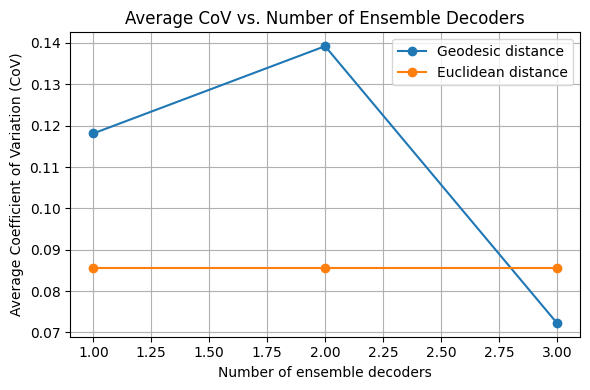

In [177]:
plot_and_save_avg_cov(geodesic_avg_covs, euclidean_avg_covs, decoder_counts)



In [178]:
import shutil
from google.colab import files

# 打包整个 /content 目录
shutil.make_archive('figure2', 'zip', '/content')

# 下载打包后的文件
files.download('figure2.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>